# WIP

# Experiment 4: Trained the network with 5 subjects at aspect angle 0 degree then tested on the 6th subject at aspect angles 0, 30, 45 and 60 degrees



*   Trained with 5 subjects at aspect angle 0 degrees
*   Tested on the 6th subject for 0, 30, 45 and 60 degrees
*   **Possibly no walking?**
*  **\*# CHANGE SO NOT TRAINING ON ALL: TRAIN ONCE -> Evaluate on all tests\* **



## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    FILE_PATH = '/content/gdrive/My Drive/Level-4-Project/data/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
else:
    FILE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/data/"
    
#  from src.models.original_models import cifar_xdeg  # model from files
from src.models.original_models import cnn_64_128  # Paper claims this model

from src.data import load_data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report,confusion_matrix
import csv
from keras.models import load_model

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [0]:
data_folders = ['mixed_angle_A', 'cifar_30deg', 'cifar_45deg', 'cifar_60deg']

In [0]:
batch_size = 100
nb_classes = 6
nb_epoch = 100
nb_epoch = 10
data_augmentation = False
nb_train_samples = 34260

# input image dimensions
img_rows, img_cols = 75, 75
# the CIFAR10 images are RGB

In [0]:
# the data, shuffled and split between train and test sets
(X_train_default, y_train_default), (X_test, y_test) = load_data.load_data((FILE_PATH + 'cifar_30deg'), nb_train_samples)

## Training and Evaluating Models

In [8]:
data_sets = {}
for data_folder in data_folders:    
    if data_folder == "mixed_angle_A":
        # use mixed angle A test set but 30 deg train set
        X_test, y_test = load_data.load_batch(FILE_PATH + data_folder + '/test_batch')
        y_test = np.reshape(y_test, (len(y_test), 1))
        X_train = X_train_default
        y_train = y_train_default
    
    else:
        # the data, shuffled and split between train and test sets
        (X_train, y_train), (X_test, y_test) = load_data.load_data((FILE_PATH + data_folder), nb_train_samples)
                                                                   
    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    
    model = cnn_64_128.make_model(img_rows, img_cols, nb_classes)
    
    # let's train the model using SGD + momentum (how original).
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(
            X_train,
            Y_train,
            batch_size=batch_size,
            epochs=nb_epoch,
            validation_data=(X_test, Y_test),
            shuffle=True, 
            verbose=1)

        y_pred = model.predict_classes(X_test)
        target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting']
        data_sets[data_folder] = {"model": model}
        data_sets[data_folder].update({"history": history})
        data_sets[data_folder].update({
            "classification_report": classification_report(
                np.argmax(Y_test,axis=1), y_pred,target_names=target_names)
        })
        data_sets[data_folder].update({
            "confusion_matrix": confusion_matrix(
                np.argmax(Y_test,axis=1), y_pred)
        })

        #     model.save('/home/aleksandar/sets/cifar_30deg/results/model_30deg.h5')

    else:
        print('Using real-time data augmentation.')

        # this will do preprocessing and realtime data augmentation
        datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False)  # randomly flip images

        # compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied)
        datagen.fit(X_train)

        # fit the model on the batches generated by datagen.flow()
        hist = model.fit_generator(datagen.flow(X_train, Y_train,
                          batch_size=batch_size),
                          samples_per_epoch=X_train.shape[0],
                          nb_epoch=nb_epoch,
                          validation_data=(X_test, Y_test))

        y_pred = model.predict_classes(X_test)
        print(y_pred)
        target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting']
        #     sys.stdout = open('/home/aleksandar/sets/cifar_30deg/results/report_30deg.txt', "w")
        print("CLASSIFICATION REPORT:")
        print(classification_report(np.argmax(Y_test,axis=1), y_pred,target_names=target_names))
        print ("\n")
        print("CONFUSION MATRIX:")
        print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))

        #     with open('/home/aleksandar/sets/cifar_30deg/results/graphs_30deg.csv', "w") as f:
        #        w = csv.writer(f)
        #        train_loss = hist.history['loss']
        #        val_loss = hist.history['val_loss']
        #        train_acc = hist.history['acc']
        #        val_acc = hist.history['val_acc']
        #        helplist = list(zip(train_loss, train_acc, val_loss, val_acc))
        #        w.writerow("train_loss, train_acc, val_loss, val_acc")
        #        for val in helplist:
        #           w.writerow([val])


        #     model.save('/home/aleksandar/sets/cifar_30deg/results/model_30deg.h5')

Not using data augmentation.
Train on 34260 samples, validate on 8690 samples
Epoch 1/10
34260/34260 [==============================] - 73s 2ms/step - loss: 0.5762 - acc: 0.7715 - val_loss: 1.7850 - val_acc: 0.6074
Epoch 2/10
34260/34260 [==============================] - 70s 2ms/step - loss: 0.0915 - acc: 0.9699 - val_loss: 2.6225 - val_acc: 0.5834
Epoch 3/10
34260/34260 [==============================] - 70s 2ms/step - loss: 0.0451 - acc: 0.9849 - val_loss: 2.8514 - val_acc: 0.5673
Epoch 4/10
34260/34260 [==============================] - 70s 2ms/step - loss: 0.0272 - acc: 0.9907 - val_loss: 2.7044 - val_acc: 0.5545
Epoch 5/10
34260/34260 [==============================] - 70s 2ms/step - loss: 0.0193 - acc: 0.9933 - val_loss: 3.3610 - val_acc: 0.5403
Epoch 6/10
34260/34260 [==============================] - 70s 2ms/step - loss: 0.0148 - acc: 0.9952 - val_loss: 4.0282 - val_acc: 0.5509
Epoch 7/10
34260/34260 [==============================] - 70s 2ms/step - loss: 0.0114 - acc: 0.9963 

## Analysis

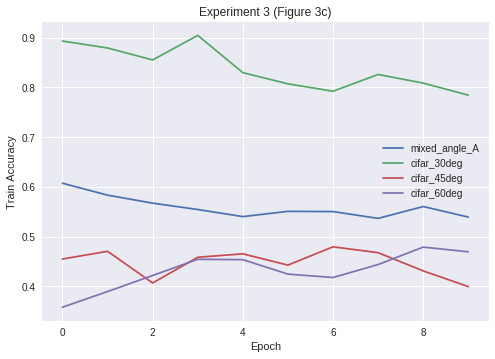

In [9]:
import matplotlib.pyplot as plt

for key, data_set in data_sets.items():
    plt.plot(data_set["history"].history['val_acc'], label=key)
    
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Experiment 3 (Figure 3c)')
plt.show()